## first simple domain adaptation (noise + lobe segments)

In [1]:
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter
import glob
import shutil
import os
from tqdm import tqdm
import yaml
from multiprocessing import Pool

In [2]:
def add_noise(volume, mean, std):
    noise = np.random.normal(mean, std, volume.shape)
    noise = noise.reshape(volume.shape)
    
    num_salt = 512*512*500 * 0.0001
    coords = [np.random.randint(5, i - 5, int(num_salt)) for i in volume.shape]
    for x, y, z in zip(coords[0],coords[1],coords[2]):
        noise[x-1:x+2, y-1:y+2, z-1:z+2] += -0.8
        
    gauss = gaussian_filter(noise, sigma=1)
    noisy = volume + gauss
    
    return noisy, gauss

In [3]:
def adapt(args):
    in_dir, out_dir, orig_dir, trachea = args
    hash = in_dir.split('/')[-1]
    with open(f'{in_dir}/config.yml', "r") as filepath:
        config = yaml.safe_load(filepath)
    scan = config['Forest']['segment_root_path'][-13:-10]
    
    vol = nib.load(in_dir + '/volume.nii.gz').get_fdata().astype(np.float32)
    vol = vol / 255

    lung_mask = nib.load(in_dir + '/lung.nii.gz').get_fdata().astype(np.uint8)
    lung_mask = lung_mask >= 1

    wall_mask = nib.load(in_dir + '/airway_wall.nii.gz').get_fdata().astype(np.uint8)
    wall_mask = wall_mask >= 1

    airway_mask = nib.load(in_dir + '/airways.nii.gz').get_fdata().astype(np.uint8)
    airway_mask = airway_mask >= 1

    # add lung background
    adapted_vol = lung_mask.astype(np.uint8) * 0.9
    # add airway walls
    adapted_vol[wall_mask] = vol[wall_mask] / 10
    # add airways
    adapted_vol[airway_mask] = vol[airway_mask]
    adapted_vol = gaussian_filter(adapted_vol, sigma=0.8)

    del vol, wall_mask
    
    adapted_vol, _ = add_noise(adapted_vol, mean=0, std=0.2)
    
    adapted_vol *= -950

    orig_img = nib.load(f'{orig_dir}/images/ATM_{scan}_0000.nii.gz')
    orig_vol = orig_img.get_fdata()
    affine = orig_img.affine
    del orig_img

    # add original background
    adapted_vol[lung_mask == False] = orig_vol[lung_mask == False]
    adapted_vol = adapted_vol.astype(np.float32)

    nifti = nib.Nifti1Image(adapted_vol, affine)
    nib.save(nifti, f"{out_dir}/images/{hash}_adapted_vol.nii.gz")

    if trachea:
        orig_seg = nib.load(f'{orig_dir}/labels/ATM_{scan}_0000.nii.gz').get_fdata()
        main_bronchi = np.where(np.bitwise_and(lung_mask == False, orig_seg >= 1), True, False)
        adapted_airway = airway_mask.astype(np.uint8)
        adapted_airway[main_bronchi] = 1
        nifti = nib.Nifti1Image(adapted_airway, affine) #np.eye(4))
    else:
        nifti = nib.Nifti1Image(airway_mask.astype(np.uint8), affine)
    nib.save(nifti, f"{out_dir}/labels/{hash}_adapted_label.nii.gz")

## dataset_2

In [ ]:
in_dir = '/home/ahaas/airway-seg/vessel_graph_generation/datasets/dataset_1'
out_dir = '/home/ahaas/airway-seg/vessel_graph_generation/datasets/dataset_2'
    
for folder in glob.glob('/home/ahaas/airway-seg/vessel_graph_generation/datasets/lobes/*'):
    hash = folder.split('/')[-1]
    shutil.copyfile(f'{in_dir}/images/{hash}_adapted_vol.nii.gz', f'{out_dir}/images/{hash}_adapted_vol.nii.gz')
    affine = nib.load(f'{in_dir}/images/{hash}_adapted_vol.nii.gz').affine
    
    airway_mask = np.load(folder + '/airways.npy').astype(np.uint8)
    airway_mask = airway_mask >= 1
    
    nifti = nib.Nifti1Image(airway_mask.astype(np.uint8), affine) #np.eye(4))
    nib.save(nifti, f"{out_dir}/labels/{hash}_adapted_label.nii.gz")

## dataset_3

In [ ]:
in_dirs = sorted(glob.glob('/home/ahaas/airway-seg/vessel_graph_generation/datasets/lobes/20230817*'))
out_dir = '/home/ahaas/airway-seg/vessel_graph_generation/datasets/dataset_3'
print(out_dir)
orig_dir = '/home/shared/Data/ATM22/train/'
os.makedirs(f'{out_dir}/images', exist_ok=True)
os.makedirs(f'{out_dir}/labels', exist_ok=True)
args = []
for in_dir in in_dirs:
    args.append((in_dir, out_dir, orig_dir, False))
    #adapt(in_dir=in_dir, out_dir=out_dir, orig_dir=orig_dir, trachea=False)
with Pool(15) as p, tqdm(total=len(args)) as pbar:
    for _ in p.imap_unordered(adapt, args):
        pbar.update()

## Figures for thesis

In [1]:
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

### rule-based domain adaptations

In [3]:
root_dir = '/home/ahaas/data/1_simulated_data/dataset_2023_11_15/ATM_057_17'
out_dir = '/home/ahaas/data/figures/'
scan = 'ATM_057'
kwargs = {
    'airway_dir': f'{root_dir}/airways',
    'vessel_dir': f'{root_dir}/vessels',
    'out_dir': out_dir,
    'ATM_path': f'/home/shared/Data/ATM22/train/images/{scan}_0000.nii.gz',
    'volume_name': f'syn_{scan}',
    'no_noise': False,
}
airway_dir, vessel_dir, out_dir, ATM_path, volume_name, no_noise = kwargs.values()

In [4]:
airway = nib.load(airway_dir + '/volume.nii.gz').get_fdata().astype(np.float32)
airway_mask = airway > 0 #biggest mask

lumen = nib.load(airway_dir + '/lumen.nii.gz').get_fdata().astype(np.float32)
lumen_mask = lumen > 0 #small mask

#smallest mask
label_mask = nib.load(airway_dir + '/airways_label.nii.gz').get_fdata().astype(np.uint8) >= 1

#volume = nib.load(airway_dir + '/airway_wall.nii.gz').get_fdata().astype(np.float32)

vessels = nib.load(vessel_dir + '/volume.nii.gz').get_fdata().astype(np.float32)
vessels_mask = vessels > 0

lung_mask = nib.load(airway_dir + '/lung.nii.gz').get_fdata().astype(np.uint8)
lung_mask = lung_mask >= 1

combined_mask = np.logical_or(airway_mask, vessels_mask) #combined_volume > 0

In [5]:
airway_mapping = lambda x: 220*(x+0.2)**2-915
mapped_airway = airway_mapping(airway[airway_mask])
del airway

lumen_mapping = lambda x: 205*(x-1.35)**2-1050
mapped_lumen = lumen_mapping(lumen[label_mask])
del lumen

vessel_mapping = lambda x: 450 * (x+0.4)**2.5 - 980
mapped_vessels = vessel_mapping(vessels[vessels_mask])
vessel_noise = np.random.normal(-10, 5, np.sum(vessels_mask))
mapped_vessels += vessel_noise

adapted_volume = np.zeros_like(vessels)
adapted_volume[vessels_mask] = mapped_vessels
adapted_volume[airway_mask] = mapped_airway
adapted_volume[label_mask] = mapped_lumen

del mapped_airway
del mapped_lumen
del mapped_vessels

In [6]:
noise = np.random.uniform(0, 1, adapted_volume.shape)   
noise_smoothed = gaussian_filter(noise, sigma=(0.8, 0.8, 0.9))

# histogram equalization
min, max = noise_smoothed.min(), noise_smoothed.max()
noise_smoothed = (noise_smoothed-min) / (max-min) #normalize to [0,1]

bins = 1000 #max-min
hist, _ = np.histogram(noise_smoothed, bins=bins)
cdf1 = hist.cumsum().astype(np.float64)
cdf1 /= cdf1.max() #normalize to [0,1]

x = np.linspace(0, 1, bins) 
mu = -2.5
sig = 0.3
target_cdf = 1/(x*sig*np.sqrt(2*np.pi)+1e-5)*np.exp(-(np.log(x+1e-5)-mu)**2/(2*sig**2))
target_cdf = target_cdf.cumsum()
target_cdf /= target_cdf.max() #normalize to [0,1]

min, max = 0, 1
mapping_function = np.interp(cdf1, target_cdf, np.arange(min, max, (max-min)/bins))

noise_equalized = np.interp(noise_smoothed.ravel(), np.arange(0, 1, 1/bins), mapping_function)
noise_equalized = noise_equalized.reshape(noise_smoothed.shape)

noise_equalized_scaled = noise_equalized * 1250 - 1000

#del noise_smoothed
#del noise_equalized

In [7]:
orig_img = nib.load(ATM_path)
orig_vol = orig_img.get_fdata()
affine = orig_img.affine
del orig_img

final_volume = noise_equalized_scaled

final_volume = np.where(combined_mask, adapted_volume, final_volume) # add airways and vessels
final_volume = np.where(lung_mask, final_volume, orig_vol) # add background

In [8]:
# volume_without_equalization = noise_smoothed * 1250 - 1000
volume_without_equalization = np.where(combined_mask, adapted_volume, noise_smoothed * 1250 - 1000) # add airways and vessels
volume_without_equalization = np.where(lung_mask, volume_without_equalization, orig_vol) # add background

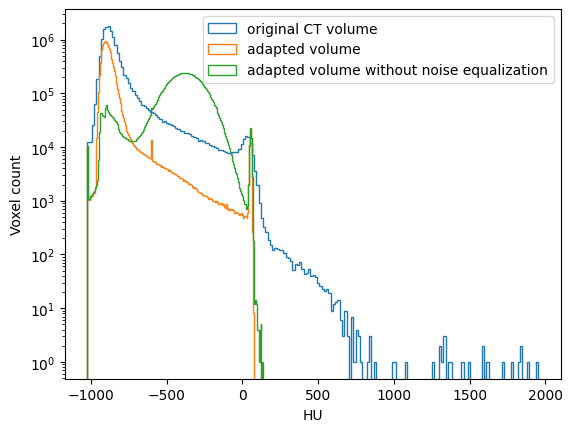

In [9]:
voxels1 = orig_vol[lung_mask].ravel()
voxels2 = final_volume[lung_mask].ravel()
voxels3 = volume_without_equalization[lung_mask].ravel()

plt.figure()
plt.hist(voxels1, bins=200, label='original CT volume', histtype='step')
plt.hist(voxels2, bins=200, label='adapted volume', histtype='step')
plt.hist(voxels3, bins=200, label='adapted volume without noise equalization', histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('HU')
plt.ylabel('Voxel count')

os.makedirs(f'{out_dir}/hist', exist_ok=True)
plt.show()

In [ ]:
plt.savefig(f'{out_dir}/hist/{volume_name}_histogram.pdf')
plt.close()

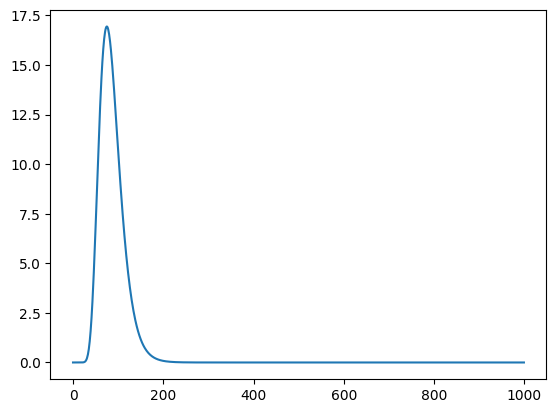

In [15]:
target_pdf = 1/(x*sig*np.sqrt(2*np.pi)+1e-5)*np.exp(-(np.log(x+1e-5)-mu)**2/(2*sig**2))

plt.figure()
plt.plot(target_pdf)
plt.show()

In [10]:
uniform = noise[lung_mask].ravel()
smoothed = noise_smoothed[lung_mask].ravel()
equalized = noise_equalized[lung_mask].ravel()
merged = final_volume[lung_mask].ravel()
structures = final_volume[combined_mask*lung_mask].ravel()
scaled_equalized = noise_equalized_scaled[lung_mask*(~combined_mask)].ravel()
original = orig_vol[lung_mask].ravel()

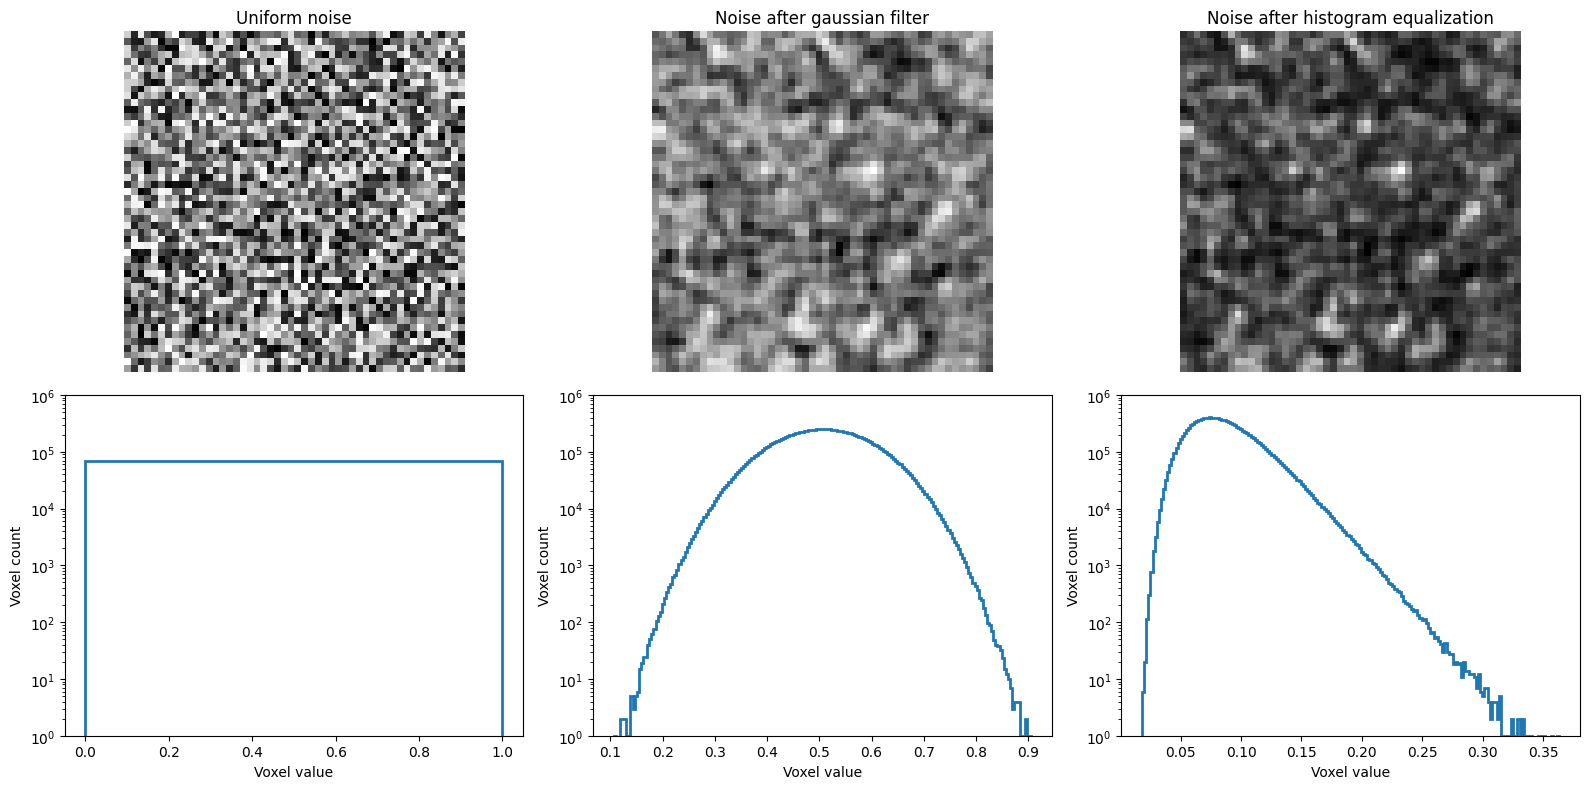

In [104]:
plt.figure(figsize=(16,8))

plt.subplot(2,3,1)
plt.imshow(noise[150:200,200:250,300], cmap='gray')
plt.axis('off')
plt.title('Uniform noise')

plt.subplot(2,3,2)
plt.imshow(noise_smoothed[150:200,200:250,300], cmap='gray')
plt.axis('off')
plt.title('Noise after gaussian filter')

plt.subplot(2,3,3)
plt.imshow(noise_equalized[150:200,200:250,300], cmap='gray')
plt.axis('off')
plt.title('Noise after histogram equalization')

plt.subplot(2,3,4)
#plt.hist(uniform, bins=200, label='uniform noise', alpha=0.75, histtype='stepfilled', facecolor='tab:blue')
plt.hist(uniform, bins=200, alpha=1, histtype='step', color='tab:blue', linewidth=2)
plt.yscale('log')
plt.ylim(1,1e6)
plt.ylabel('Voxel count')
plt.xlabel('Voxel value')

plt.subplot(2,3,5)
#plt.hist(smoothed, bins=200, label='gaussian filter', alpha=0.75, histtype='stepfilled', facecolor='tab:blue')
plt.hist(smoothed, bins=200, alpha=1, histtype='step', color='tab:blue', linewidth=2)
plt.yscale('log')
plt.ylim(1,1e6)
plt.ylabel('Voxel count')
plt.xlabel('Voxel value')
# plt.gca().yaxis.set_visible(False)

plt.subplot(2,3,6)
#plt.hist(equalized, bins=200, label='noise equalization', alpha=0.75, histtype='stepfilled', facecolor='tab:blue')
plt.hist(equalized, bins=200, alpha=1, histtype='step', color='tab:blue', linewidth=2)
plt.yscale('log')
plt.ylim(1,1e6)
plt.ylabel('Voxel count')
plt.xlabel('Voxel value')
# plt.gca().yaxis.set_visible(False)

plt.tight_layout()
plt.show()

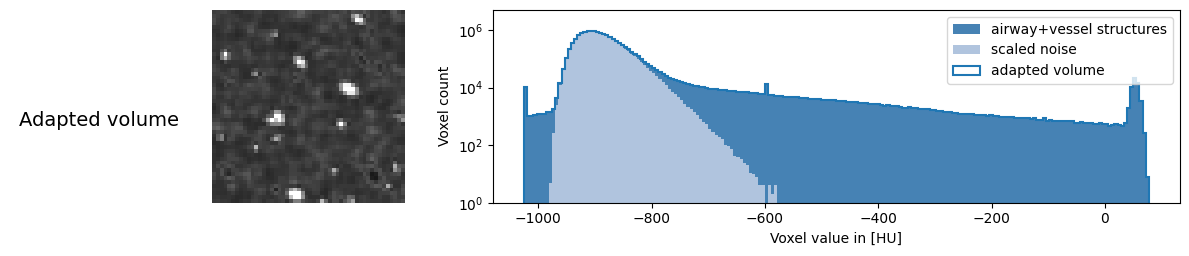

In [11]:
plt.figure(figsize=(12,3))

gs = plt.GridSpec(1, 3, width_ratios=[1, 2, 6])

plt.subplot(gs[0])
plt.suptitle('Adapted volume', x=0.02, y=0.5, ha='left', fontsize=14)
plt.axis('off')

plt.subplot(gs[1])
plt.imshow(final_volume[150:200,200:250,300], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')

plt.subplot(gs[2])
plt.hist([scaled_equalized, structures, ], bins=200, label=('scaled noise', 'airway+vessel structures'),
         histtype='stepfilled', color=('lightsteelblue', 'steelblue'),
         linewidth=1.5, alpha=1, stacked=True)
plt.hist(merged, bins=200, label='adapted volume', histtype='step', color='tab:blue', linewidth=1.5, alpha=1)

plt.yscale('log')
plt.ylim(1,5e6)
plt.ylabel('Voxel count')
plt.xlabel('Voxel value in [HU]')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'{out_dir}/adapted_volume.pdf')

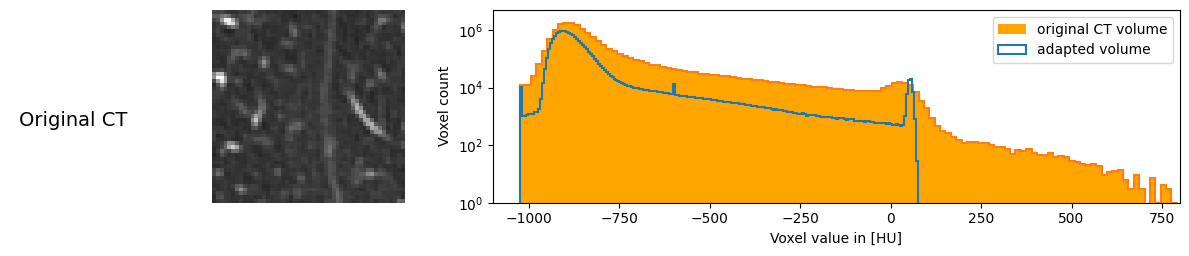

In [253]:
plt.figure(figsize=(12,3))

gs = plt.GridSpec(1, 3, width_ratios=[1, 2, 6])

plt.subplot(gs[0])
plt.suptitle('Original CT', x=0.02, y=0.5, ha='left', fontsize=14)
plt.axis('off')

plt.subplot(gs[1])
plt.imshow(orig_vol[150:200,200:250,300], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')
plt.ylabel('Original volume', fontsize=15)

plt.subplot(gs[2])
plt.hist(original, bins=200, histtype='step', color='tab:orange', linewidth=1.5, alpha=1)
plt.hist(original, bins=200, label='original CT volume', histtype='stepfilled', color='orange', linewidth=1.5, alpha=1)
plt.hist(merged, bins=200, label='adapted volume', histtype='step', color='tab:blue', linewidth=1.5, alpha=1)

plt.yscale('log')
plt.ylim(1,5e6)
plt.xlim(-1100, 800)
plt.ylabel('Voxel count')
plt.xlabel('Voxel value in [HU]')
plt.legend()

plt.tight_layout()
plt.savefig(f'{out_dir}/original_volume.pdf')

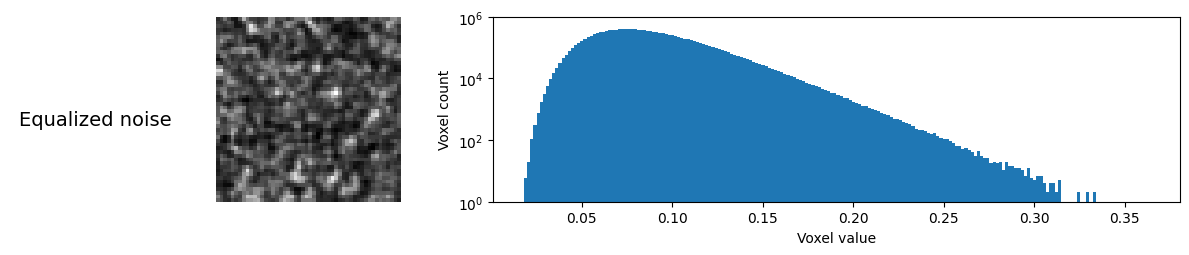

In [260]:
plt.figure(figsize=(12,3))

gs = plt.GridSpec(1, 3, width_ratios=[1, 2, 6])

plt.subplot(gs[0])
plt.suptitle('Equalized noise', x=0.02, y=0.5, ha='left', fontsize=14)
plt.axis('off')

plt.subplot(gs[1])
plt.imshow(noise_equalized[150:200,200:250,300], cmap='gray')
plt.axis('off')

plt.subplot(gs[2])
plt.hist(equalized, bins=200, alpha=1, histtype='stepfilled', color='tab:blue', linewidth=2)
plt.yscale('log')
plt.ylim(1,1e6)
plt.ylabel('Voxel count')
plt.xlabel('Voxel value')

plt.tight_layout()
plt.savefig(f'{out_dir}/noise_equalized.pdf')

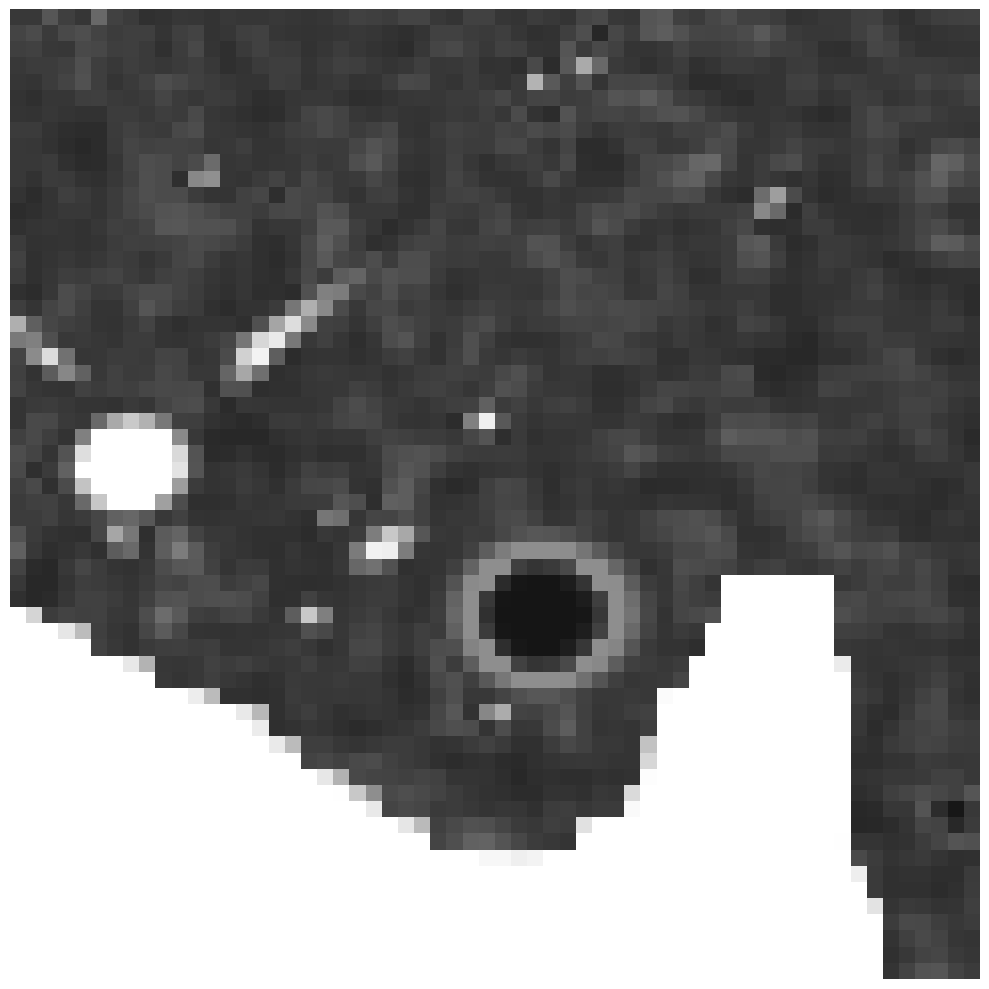

In [29]:
plt.figure(figsize=(10, 10))

plt.imshow(final_volume[180:240,240:300,350], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{out_dir}/artifacts.png')

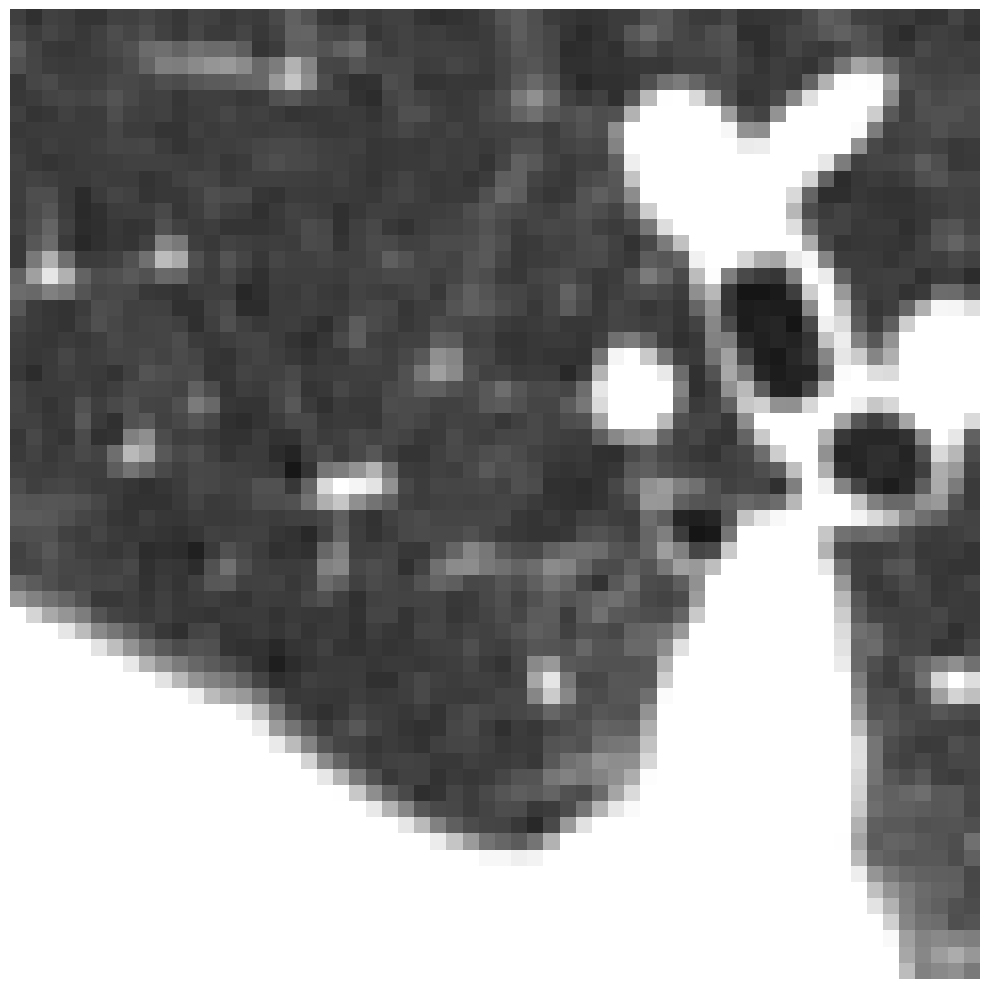

In [30]:
plt.figure(figsize=(10, 10))

plt.imshow(orig_vol[180:240,240:300,350], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{out_dir}/no_artifacts.png')

<Figure size 640x480 with 0 Axes>

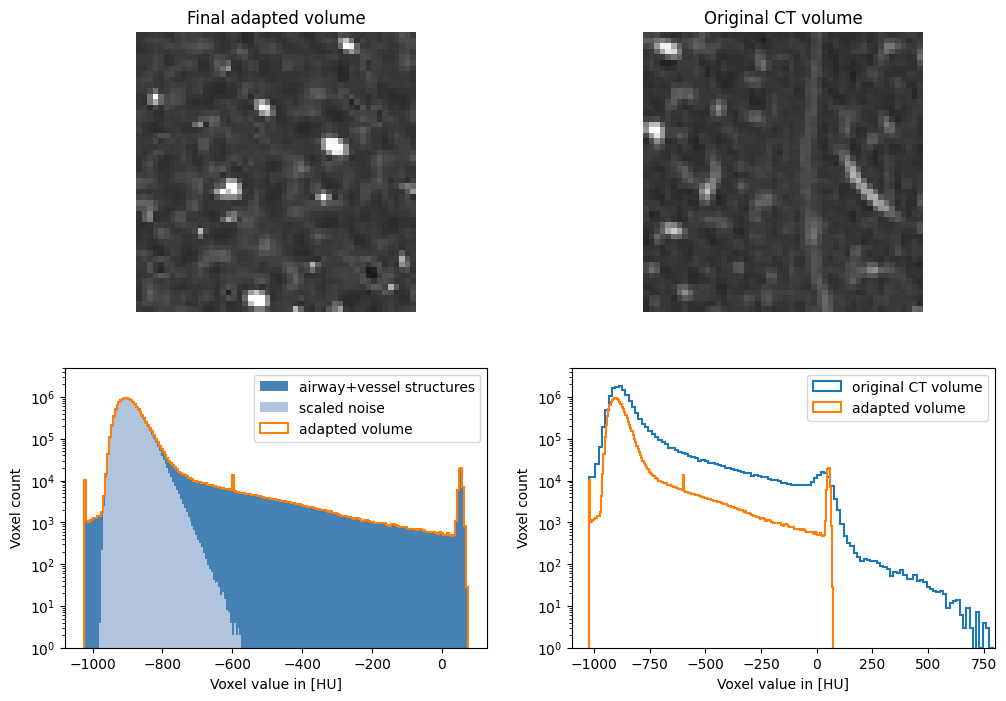

<Figure size 640x480 with 0 Axes>

In [181]:

plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.imshow(final_volume[150:200,200:250,300], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')
plt.title('Final adapted volume')

plt.subplot(2,2,2)
plt.imshow(orig_vol[150:200,200:250,300], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')
plt.title('Original CT volume')

plt.subplot(2,2,3)
#plt.hist(merged, bins=200, label='final volume', alpha=0.75, histtype='stepfilled', facecolor='tab:blue')
plt.hist([scaled_equalized, structures, ], bins=200, label=('scaled noise', 'airway+vessel structures'),
         histtype='stepfilled', color=('lightsteelblue', 'steelblue'),
         linewidth=1.5, alpha=1, stacked=True)
#plt.hist(structures, bins=200, label='airway + vessel structures', histtype='step', color='tab:red', linewidth=1.5, alpha=0.75, stacked=True)
plt.hist(merged, bins=200, label='adapted volume', histtype='step', color='tab:orange', linewidth=1.5, alpha=1)

plt.yscale('log')
plt.ylim(1,5e6)
plt.ylabel('Voxel count')
plt.xlabel('Voxel value in [HU]')
plt.legend()

plt.subplot(2,2,4) 
#plt.hist(original, bins=200, label='original volume', alpha=0.75, histtype='stepfilled', facecolor='tab:blue')
plt.hist(original, bins=200, label='original CT volume', histtype='step', color='tab:blue', linewidth=1.5, alpha=1)
plt.hist(merged, bins=200, label='adapted volume', histtype='step', color='tab:orange', linewidth=1.5, alpha=1)

plt.yscale('log')
plt.ylim(1,5e6)
plt.xlim(-1100, 800)
plt.ylabel('Voxel count')
plt.xlabel('Voxel value in [HU]')
plt.legend()

plt.figure()


In [24]:
syn_vol = nib.load('/home/ahaas/data/3_deformed_data/dataset_2023_11_15/images/syn_ATM_057_17_0_volume.nii.gz').get_fdata()
orig_vol = nib.load('/home/ahaas/data/3_deformed_data/ATM22/train/images/ATM_057_0_volume.nii.gz').get_fdata()
cyclegan_vol = nib.load('/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_1slices_0.5idt/test_latest/syn_ATM_057_17_0_volume/fake_B_syn_ATM_057_17_0_volume.nii.gz').get_fdata()
fake_syn_vol = nib.load('/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_1slices_0.5idt/test_latest/syn_ATM_057_17_0_volume/fake_A_syn_ATM_057_17_0_volume.nii.gz').get_fdata()
out_dir = '/home/ahaas/data/figures'

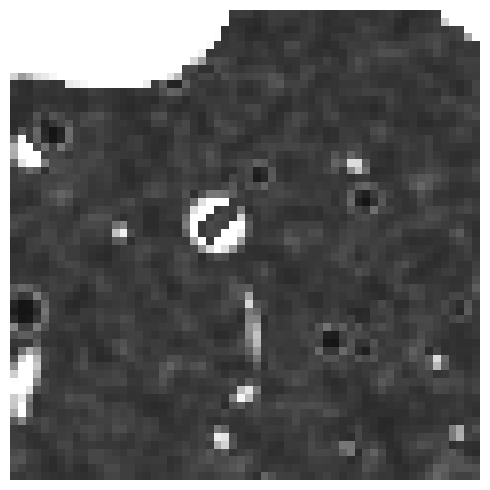

In [29]:
plt.figure(figsize=(5, 5))

plt.imshow(syn_vol[190:250,140:200,250], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{out_dir}/cyclegan/real_syn_vol.png')

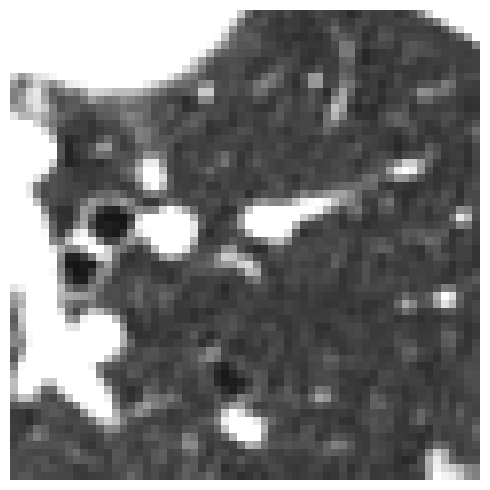

In [28]:
plt.figure(figsize=(5, 5))

plt.imshow(orig_vol[190:250,140:200,250], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{out_dir}/cyclegan/real_orig_vol.png')

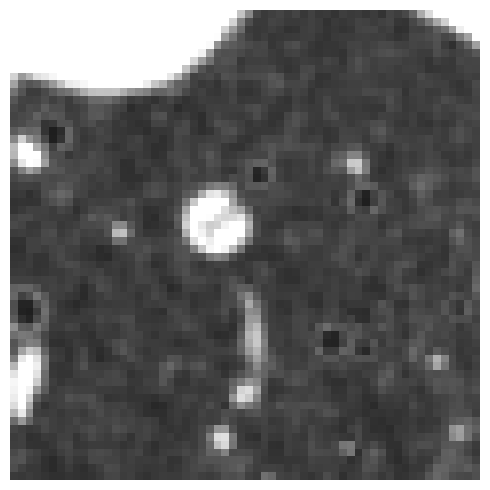

In [27]:
plt.figure(figsize=(5, 5))

plt.imshow(cyclegan_vol[190:250,140:200,250], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{out_dir}/cyclegan/fake_orig_vol.png')

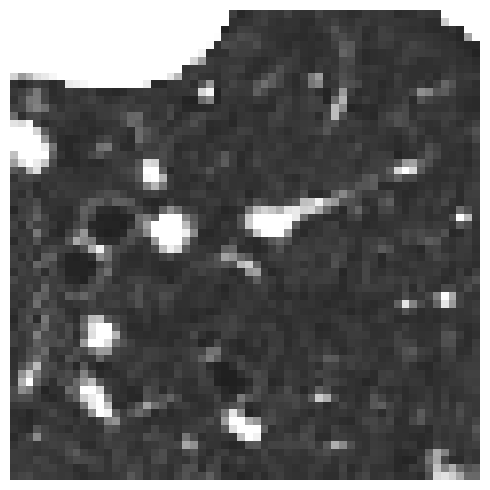

In [26]:
plt.figure(figsize=(5, 5))

plt.imshow(fake_syn_vol[190:250,140:200,250], cmap='gray', vmin=-1100, vmax=-200)
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{out_dir}/cyclegan/fake_syn_vol.png')

### translation overview

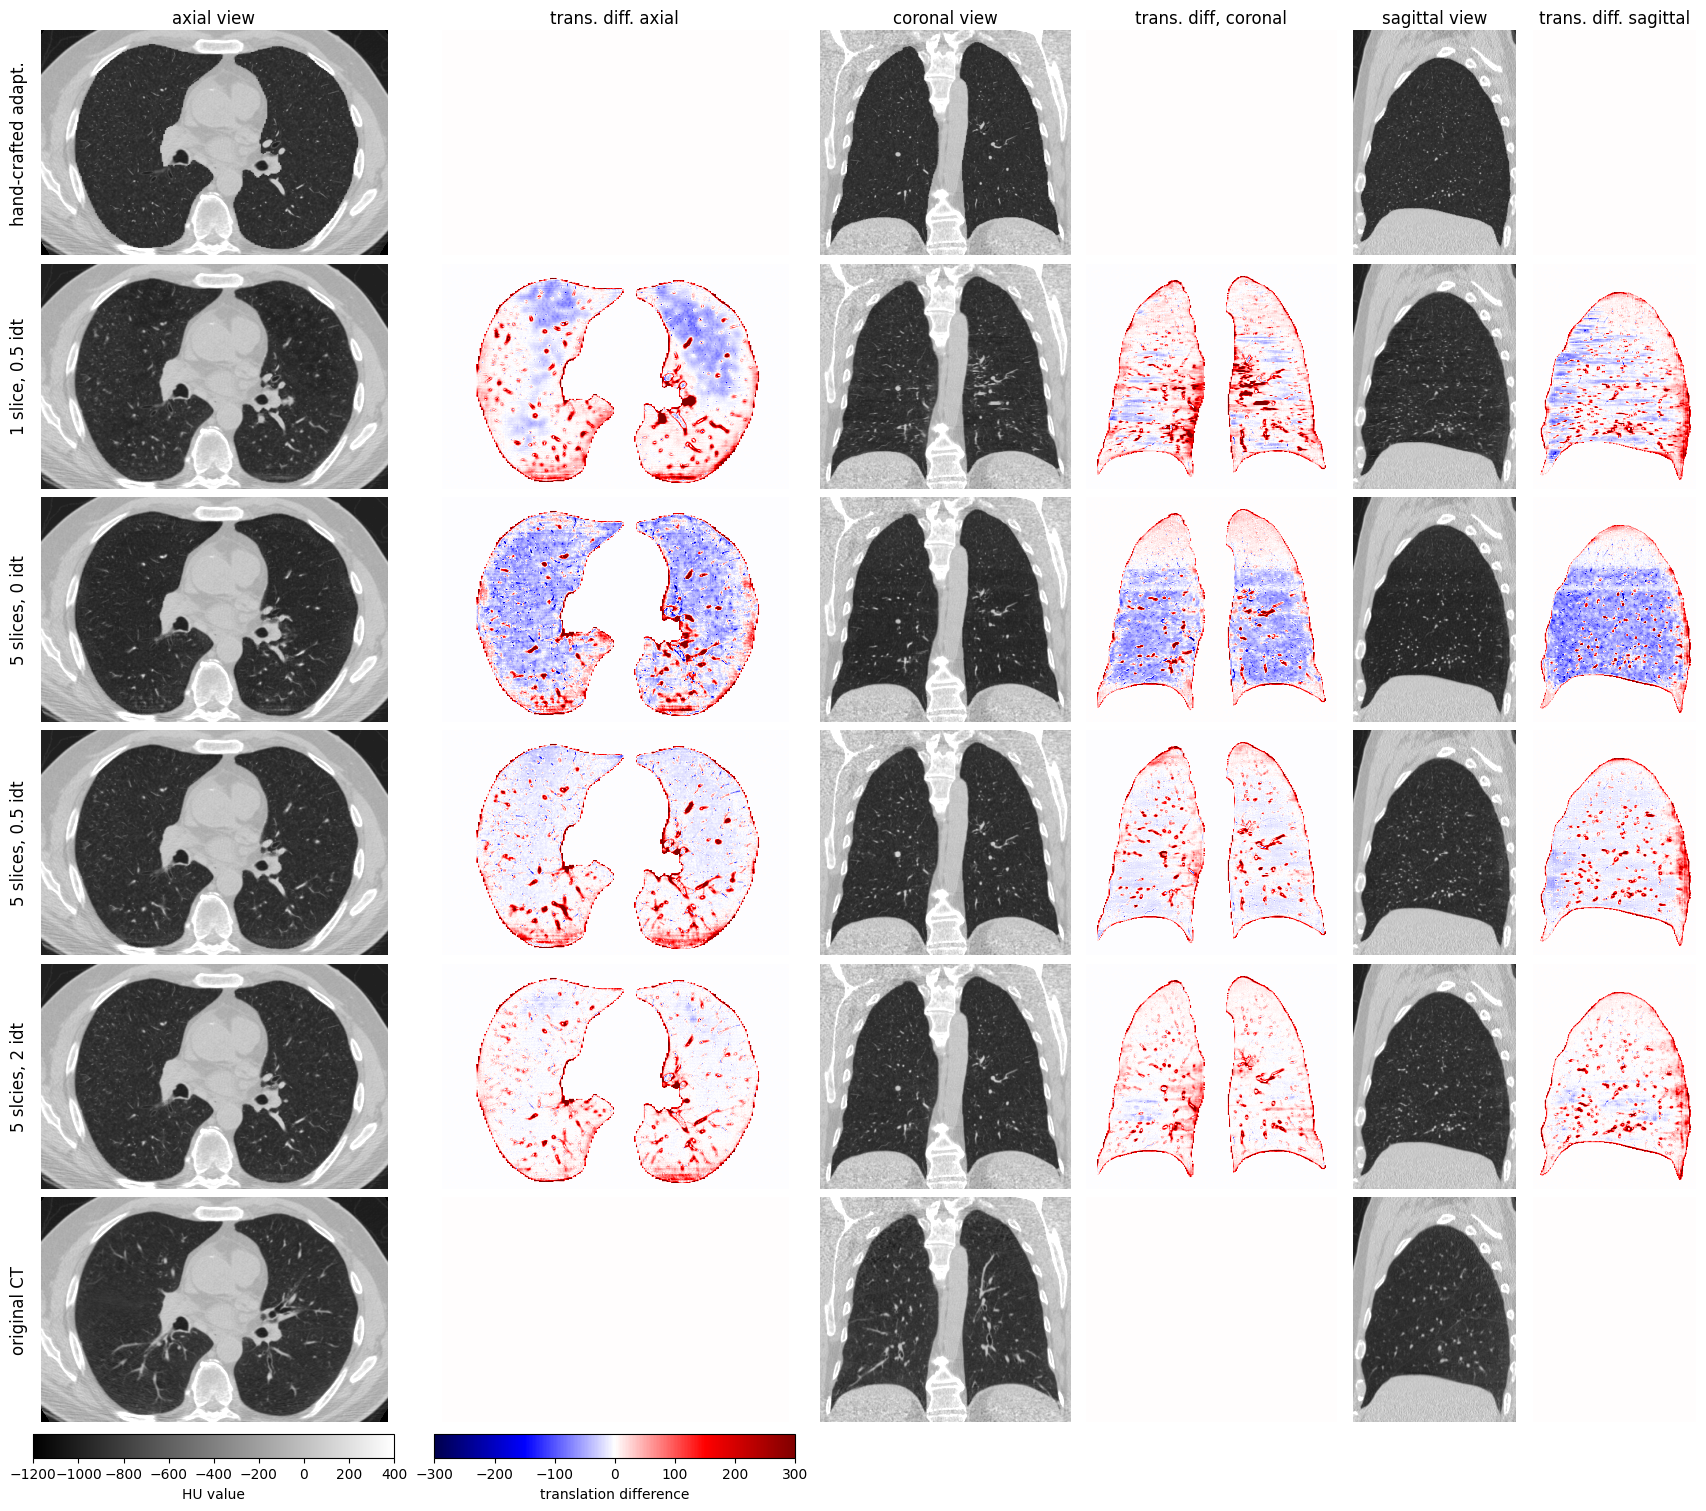

In [26]:

out_dir = '/home/ahaas/data/figures/evaluation'
scan = '221'
files = [(f'/home/ahaas/data/3_deformed_data/dataset_2023_11_15/images/syn_ATM_{scan}_00_0_volume.nii.gz', None),
         (f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_1slices_0.5idt/train/images/syn_ATM_{scan}_00_0_volume.nii.gz',
          f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_1slices_0.5idt/train/diff/syn_ATM_{scan}_00_0_volume.nii.gz'),
         (f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_5slices_0idt/train/images/syn_ATM_{scan}_00_0_volume.nii.gz',
          f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_5slices_0idt/train/diff/syn_ATM_{scan}_00_0_volume.nii.gz'),
         (f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_5slices_0.5idt/train/images/syn_ATM_{scan}_00_0_volume.nii.gz',
          f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_5slices_0.5idt/train/diff/syn_ATM_{scan}_00_0_volume.nii.gz'),
         (f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_5slices_2idt/train/images/syn_ATM_{scan}_00_0_volume.nii.gz',
          f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_5slices_2idt/train/diff/syn_ATM_{scan}_00_0_volume.nii.gz'),
         (f'/home/ahaas/data/3_deformed_data/ATM22/train/images/ATM_{scan}_0_volume.nii.gz', None)]
titles_row = ['hand-crafted adapt.', '1 slice, 0.5 idt', '5 slices, 0 idt', '5 slices, 0.5 idt', '5 slcies, 2 idt', 'original CT']
titles_column = ['axial view', 'trans. diff. axial', 'coronal view', 'trans. diff, coronal', 'sagittal view', 'trans. diff. sagittal']
vmin, vmax = -1200, 400
vmin_diff, vmax_diff = -300, 300


fig, axs = plt.subplots(len(files), 6, figsize=(17, len(files)*2.5), gridspec_kw={'width_ratios': [2.1, 2.1, 1.5, 1.5, 1, 1]}, layout='constrained')


for i, (file_path, diff_path) in enumerate(files):
    vol = nib.load(file_path).get_fdata()
    vol = np.rot90(vol, k=1, axes=(0,2))
    if diff_path is not None:
        diff = nib.load(diff_path).get_fdata()
        diff = np.rot90(diff, k=1, axes=(0,2))
    else:
        diff = np.zeros_like(vol)

    axs[i, 0].imshow(vol[200,:,:], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i, 0].axis('off')
    #axs[i, 0].set_title(titles_row[i], rotation='vertical', x=-0.05, y=0.05)
    axs[i, 0].annotate(titles_row[i], xy=(0, 0.5), xytext=(-axs[i, 0].yaxis.labelpad - 5, 0),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='right', va='center', rotation='vertical')

    axs[i, 1].imshow(diff[200,:,:], cmap='seismic', vmin=vmin_diff, vmax=vmax_diff)
    axs[i, 1].axis('off')

    axs[i, 2].imshow(vol[:,200,:], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i, 2].axis('off')

    axs[i, 3].imshow(diff[:,200,:], cmap='seismic', vmin=vmin_diff, vmax=vmax_diff)
    axs[i, 3].axis('off')

    im = axs[i, 4].imshow(vol[:,:,100], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i, 4].axis('off')

    im_diff = axs[i, 5].imshow(diff[:,:,100], cmap='seismic', vmin=vmin_diff, vmax=vmax_diff)
    axs[i, 5].axis('off')

for i, title in enumerate(titles_column):
    axs[0, i].annotate(title, xy=(0.5, 1), xytext=(0, 5), xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', size='large')
plt.colorbar(im, ax=axs[-1, 0], orientation='horizontal', location='bottom', label='HU value', aspect=15)
plt.colorbar(im_diff, ax=axs[-1, 1], orientation='horizontal', location='bottom', label='translation difference', aspect=15)
#plt.show()
plt.savefig(f'{out_dir}/translation_overview.pdf')


- figure showing the translated volumes for different model parameters. columns show axial, coronal and sagittal view with corresponding translation difference visualization. blue color indicates negative changes of HU values, while red color shows positive changes.
- first row is the basis volume after hand-crafted adaptations, last row shows an original CT as reference. Rows inbetween are the different experiments for varing model parameters

- as predicted, as hoped for: looking at translation difference plot, large changes at mask borders -> smooth transition between original scan and synthetic area
- all in all: vessels were exaggerated, made larger and more present

- especially for 1 slice variations: looking at orthogonal views coronal and sagittal (not trained and infered plain): line artifacts in axial direction. resulting from information lack between global axial slices
- other variations also show artifacts due to 2D (2.5D) model

- 0 idt variations: show larger translation differences (especially in negative direction) compared to more restricted experiments with idt = 0.5 or idt = 2

### histogram

In [54]:
scan = '027'
experiment = '5slices_0.5idt'
mask_path = f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_{experiment}/train/masks/syn_ATM_{scan}_00_0_mask.nii.gz'
file_path = f'/home/ahaas/data/5_out_cyclegan/dataset_2023_11_15_{experiment}/train/images/syn_ATM_{scan}_00_0_volume.nii.gz'
hand_craft_path = f'/home/ahaas/data/3_deformed_data/dataset_2023_11_15/images/syn_ATM_{scan}_00_0_volume.nii.gz'
orig_path = f'/home/ahaas/data/3_deformed_data/ATM22/train/images/ATM_{scan}_0_volume.nii.gz'

mask = nib.load(mask_path).get_fdata()
vol = nib.load(file_path).get_fdata()
vol_hand = nib.load(hand_craft_path).get_fdata()
vol_orig = nib.load(orig_path).get_fdata()

vol_voxels = vol[mask == 1]
vol_hand_voxels = vol_hand[mask == 1]
vol_orig_voxels = vol_orig[mask == 1]

print('translated', vol_voxels.min(), vol_voxels.max())
print('hand-crafted', vol_hand_voxels.min(), vol_hand_voxels.max())
print('original', vol_orig_voxels.min(), vol_orig_voxels.max())

translated -997.0 291.0
hand-crafted -1024.0 72.0
original -1024.0 822.0


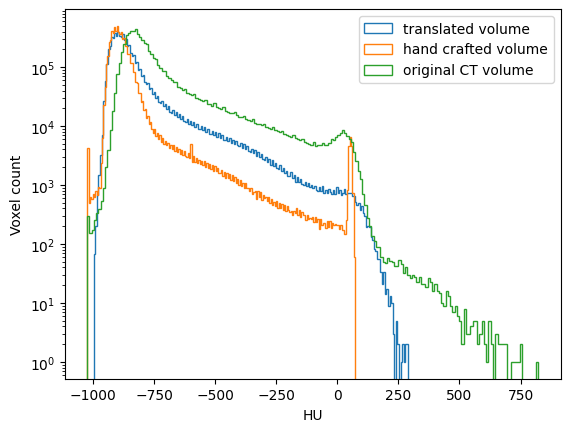

In [55]:
plt.figure()
plt.hist(vol_voxels, bins=200, label='translated volume', histtype='step')
plt.hist(vol_hand_voxels, bins=200, label='hand crafted volume', histtype='step')
plt.hist(vol_orig_voxels, bins=200, label='original CT volume', histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('HU')
plt.ylabel('Voxel count')

plt.show()